In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torch.utils.data import random_split
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
from thermostability.thermo_dataset import ThermostabilityDataset
from util.telegram import TelegramBot
from tqdm.notebook import tqdm
import sys
from util.train import train_model
from torch import nn
from uni_prot.dense_model import DenseModel

cudnn.benchmark = True

if torch.cuda.is_available():
    torch.cuda.empty_cache() 
    
cpu = torch.device("cpu")

torch.cuda.list_gpu_processes()
telegramBot = TelegramBot()



/hpi/fs00/home/hoangan.nguyen/anaconda3/envs/hotshot/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from uni_prot.uni_prot_dataset import UniProtDataset
train_ds = UniProtDataset("train.csv", limit=16)
val_ds = UniProtDataset("val.csv", limit=16)

In [3]:
import torch
from torch.utils.data import DataLoader
dataloaders = {
    "train": DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=2),
    "val": DataLoader(val_ds, batch_size=2, shuffle=True, num_workers=2)
}

dataset_sizes = {"train": len(train_ds),"val": len(val_ds)}
print(dataset_sizes)

{'train': 19374, 'val': 1920}


/hpi/fs00/home/hoangan.nguyen/anaconda3/envs/hotshot/lib/python3.8/site-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [4]:

model = DenseModel()
model.to("cuda:0")

criterion = nn.MSELoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [5]:
try:
   model, best_epoch_loss = train_model(model, criterion, exp_lr_scheduler, dataloaders=dataloaders, dataset_sizes=dataset_sizes, use_wandb=False,
                    num_epochs=100, prepare_labels = lambda x: x.to("cuda:0"),prepare_inputs= lambda x: x.to("cuda:0") )

except Exception as e:

   telegramBot.send_telegram(f"Training failed with error message: {str(e)}")     

Epoch 0/99
----------
train Loss: 53.4281
val Loss: 33.6873

Epoch 1/99
----------
train Loss: 34.2718
val Loss: 34.0055

Epoch 2/99
----------
train Loss: 31.2894
val Loss: 35.6441

Epoch 3/99
----------
train Loss: 29.0319
val Loss: 28.6142

Epoch 4/99
----------
train Loss: 28.2297
val Loss: 31.6567

Epoch 5/99
----------
train Loss: 27.0213
val Loss: 29.7864

Epoch 6/99
----------
train Loss: 25.9629
val Loss: 34.2680

Epoch 7/99
----------
train Loss: 20.9793
val Loss: 26.4558

Epoch 8/99
----------
train Loss: 20.4129
val Loss: 26.2726

Epoch 9/99
----------
train Loss: 20.1028
val Loss: 26.6243

Epoch 10/99
----------
train Loss: 19.8867
val Loss: 26.8386

Epoch 11/99
----------
train Loss: 19.6566
val Loss: 26.6714

Epoch 12/99
----------
train Loss: 19.4247
val Loss: 27.0546

Epoch 13/99
----------
train Loss: 19.2312
val Loss: 26.8566

Epoch 14/99
----------
train Loss: 18.5393
val Loss: 26.7272

Epoch 15/99
----------
train Loss: 18.4520
val Loss: 26.6732

Epoch 16/99
------

Infering thermostability for sample 0/960...
Diff:  tensor([-5.1479, -4.7658])
Infering thermostability for sample 1/960...
Diff:  tensor([ 2.2007, -1.3631])
Infering thermostability for sample 2/960...
Diff:  tensor([-6.1620, -5.3824])
Infering thermostability for sample 3/960...
Diff:  tensor([-1.4161,  0.9318])
Infering thermostability for sample 4/960...
Diff:  tensor([4.8488, 8.0819])
Infering thermostability for sample 5/960...
Diff:  tensor([-3.1814,  7.4280])
Infering thermostability for sample 6/960...
Diff:  tensor([-9.2742,  2.5640])
Infering thermostability for sample 7/960...
Diff:  tensor([-6.0426,  2.6208])
Infering thermostability for sample 8/960...
Diff:  tensor([ 2.9197, -1.3439])
Infering thermostability for sample 9/960...
Diff:  tensor([ 6.5630, -1.9937])
Infering thermostability for sample 10/960...
Diff:  tensor([ 0.1999, -1.8422])
Infering thermostability for sample 11/960...
Diff:  tensor([ 1.1103, -3.1026])
Infering thermostability for sample 12/960...
Diff: 

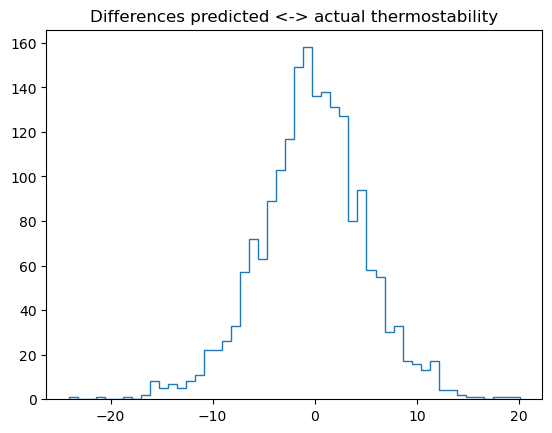

In [6]:
from datetime import datetime

def predictDiffs(set="val"):
    with torch.no_grad():
        n = len(dataloaders[set])
        diffs = torch.tensor([])
        for index, (inputs, labels) in enumerate(dataloaders[set]):
            inputs = inputs.to("cuda:0")
            print(f"Infering thermostability for sample {index}/{n}...")
            labels = labels.to("cuda:0")
            outputs = model(inputs)

            _diffs = outputs.squeeze().sub(labels.squeeze()).cpu()
            diffs = torch.cat((diffs, _diffs))
            print("Diff: ", _diffs)
    return diffs
diffs = predictDiffs()

#diffs = np.array([0, 0.1, 0.2,-0.2, -0.8, 0.1])
plt.title("Differences predicted <-> actual thermostability")
plt.hist(diffs, 50,histtype="step")
resultsDir = "results"
now = datetime.now()
time = now.strftime("%d_%m_%Y_%H:%M:%S")
os.makedirs(resultsDir, exist_ok=True)
histFile = f"results/{time}_diffs.png"
plt.savefig(histFile)
telegramBot.send_photo(histFile, f"Differences predicted <-> actual thermostability at {time}")


In [7]:
try: 
    modelPath = os.path.join(resultsDir, f"{time}_model.pth")
    torch.save(model, modelPath)
    telegramBot.send_telegram(f"Model saved at {modelPath}")
except Exception as e:
    telegramBot.send_telegram(f"Saving model failed for reason: {str(e)}")